In [188]:
import os
import requests
from tqdm import tqdm
import zipfile
import datetime
import hashlib
from base64 import b64encode

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu, ttest_ind, kstest, uniform

sns.set_theme()

# Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

##### Загрузка данных

In [4]:
# Загрузка датасета по чанкам
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|██████████| 78.8M/78.8M [01:34<00:00, 572kiB/s] 

kion dataset download: 100%|██████████| 78.8M/78.8M [01:50<00:00, 572kiB/s]

In [9]:
# Распаковываем архив из 3 файлов

with zipfile.ZipFile('./data/data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [112]:
# Чтение данных
interactions = pd.read_csv('./data/data_kion/interactions_df.csv')
users = pd.read_csv('./data/data_kion/users.csv')
items = pd.read_csv('./data/data_kion/items.csv')

# Первичные преобразования
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)
users['user_id'] = users['user_id'].astype(str)

#####  Анализ данных

In [13]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [14]:
interactions.shape

(5476251, 5)

In [15]:
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [16]:
users.shape

(840197, 5)

In [17]:
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [18]:
items.shape

(15963, 14)

<details>
  <summary>📝 Замечание </summary>
    В данных присутствует ошибка. Количество уникальных айтемов и юзеров в таблице interactions не может быть больше количества уникальных айтемов и юзеров в таблицах items и users соответственно. Однако видно, что в таблице interactions это условие для юзеров нарушается.
</details>

In [28]:
print(f"Всего уникальных юзеров: {users['user_id'].nunique():_}")
print(f"Всего уникальных айтемов: {items['item_id'].nunique():_}")
print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Всего уникальных юзеров: 840_197
Всего уникальных айтемов: 15_963
Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


# Подготовка к дизайн A/B

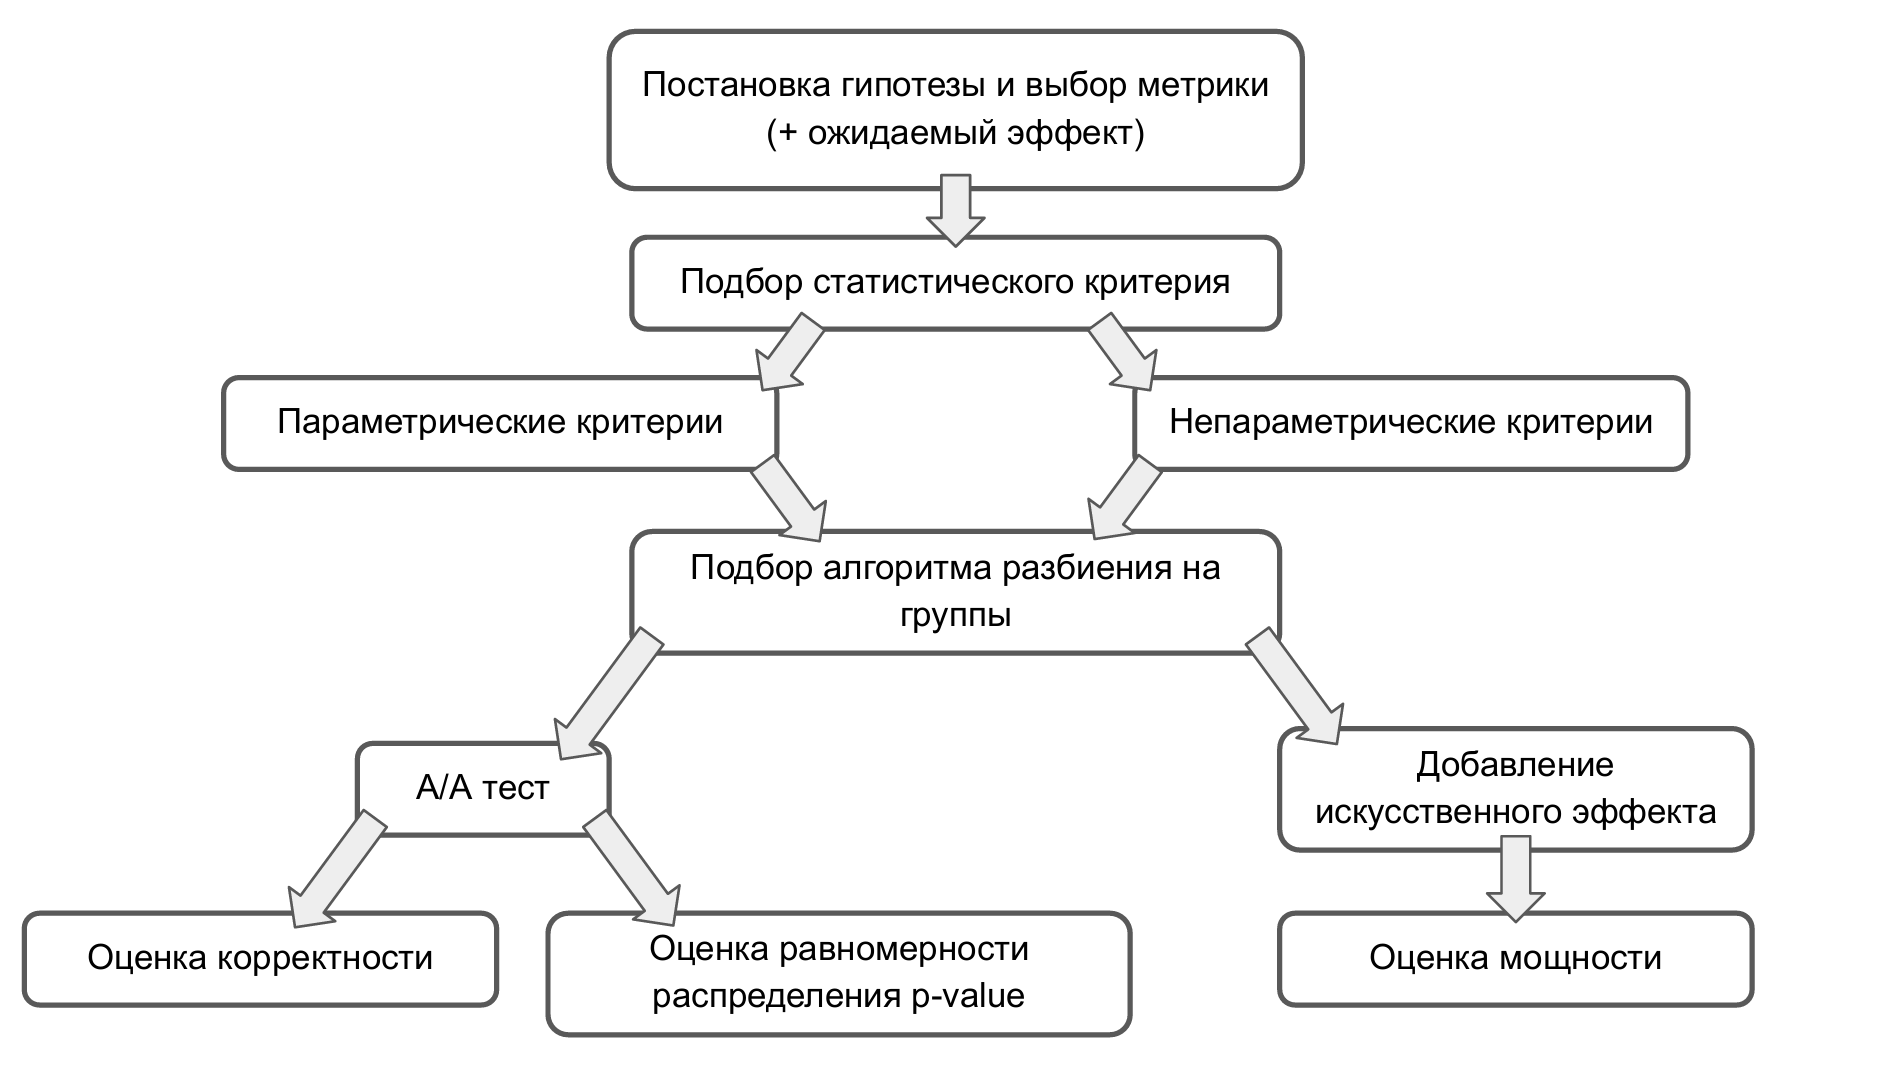

В этой работе следующий пайплайн:
- Выбор метрики и преобразования + эффект
- Выбор данных + препроцессинг + разбиение
- Выбор критерия
- Оценка корректности: посчитать корректность и сравнить с результатами за 1 неделю
- Оценка мощности: добавить эффект в 1%, 3% и 5% и сравните полученную мощность
- Оценка MDE

##### Выбор метрики
Хотим использовать метрику длину просмотра на пользователя (total_dur в датасете) - так как это основная метрика, на которую смотрит бизнес. Поэтому сакцентируем внимание на данных взаимодействий (interactions) и метрике TVTu.

<details>
    <summary>
    Преобразование Бокса-Кокса
    </summary>
    В реальности часто приходится иметь дело со статистическими данными, которые по тем или иным причинам не проходят тест на нормальность. В этой ситуации есть два выхода:
    <ul>
    <li>обратиться к непараметрическим методам</li>
    <li>воспользоваться специальными методами, позволяющими преобразовать исходную «ненормальную статистику» в «нормальную»</li>
    </ul>
    Среди множества таких методов преобразований одним из лучших (при неизвестном типе распределения) считается преобразование Бокса-Кокса.
</details>

##### Выбор эффекта 
В рассматриваемых дизайнах будет рассматриваться эффект в 1%, 3% и 5% как разница между группами.

##### Выбор данных

Для дизайна теста и самого A/B-теста могут оказаться важными следующие моменты:
- Продолжительность теста: определяет кол-во данных, а также гарантирует возможность обнаружить эффект
- Рандомные или стратифицированные выборки: на дизайне и тесте формируемые две выборки должны обладать примерно одинаковой энтропией.

<details>
  <summary>📝 Период данных </summary>
  Данные получены с 13 марта по 22 августа (меньше года)
</details>

In [46]:
# Оценка, за какой период получены данные
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


<details>
  <summary>📝 Визуализация метрики за весь период </summary>
  По графику видно увеличение метрики в летний период. Это связано с временем каникул или отпусков.
</details>

C:\Users\kshch\AppData\Local\Temp\ipykernel_17876\3330461411.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ax = interactions.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))


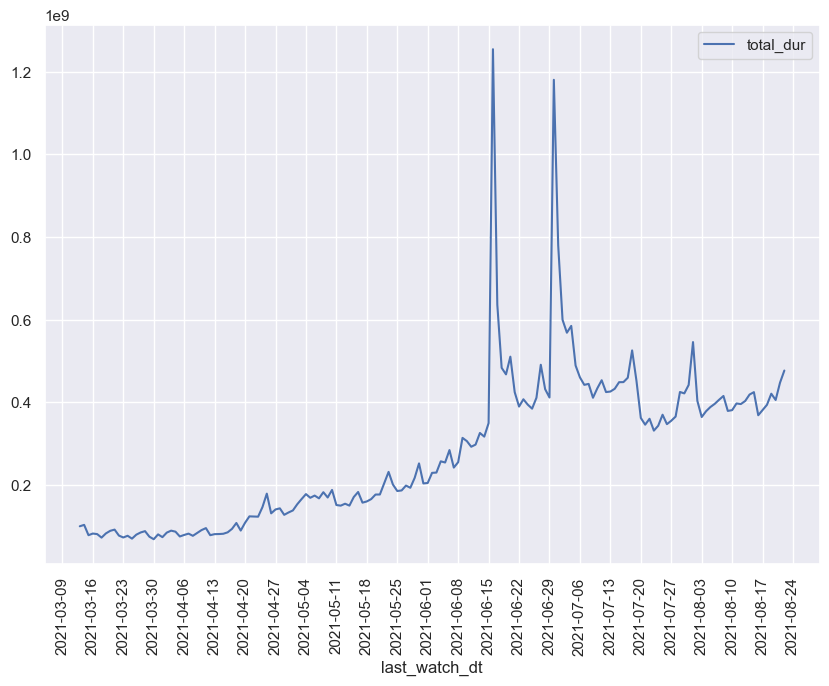

In [108]:
# Визуализация зависимости метрики от времени
ax = interactions.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

Рассмотрим последний месяц, когда метрика стабилизируется

<details>
  <summary>📝 Визуализация метрики за последний месяц </summary>
  Присутствует недельная сезонность. Сезонность позволяет ограничить длительность теста.
</details>

C:\Users\kshch\AppData\Local\Temp\ipykernel_17876\1790104849.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ax = interactions_month.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))


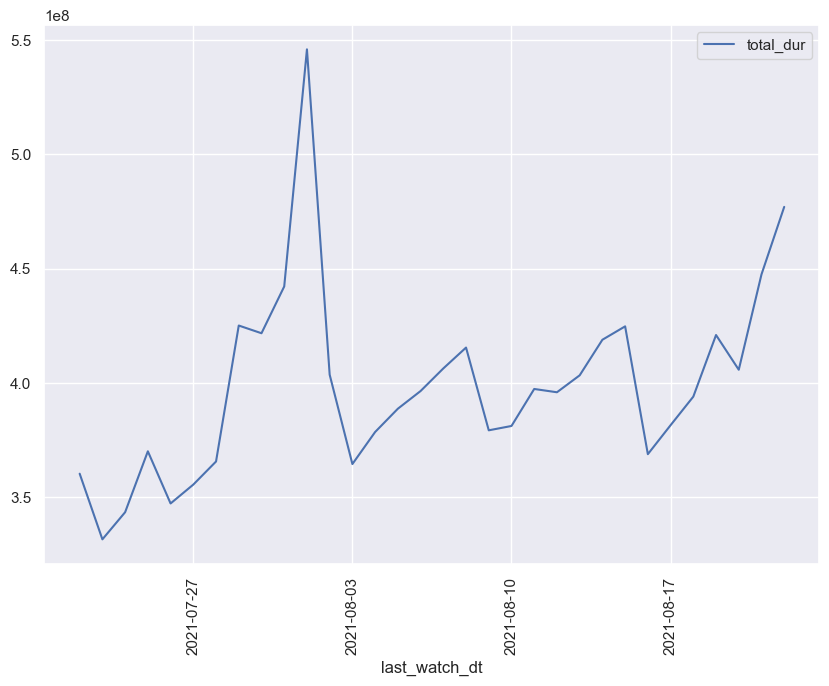

In [107]:
# Выделим данные за последний месяц
interactions_month = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=31)]
ax = interactions_month.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

Для A/B-теста оставим 2 последние недели (2021-08-09 по 2021-08-22):

In [79]:
# Выделим данные за две последние недели
interactions_2week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]

In [80]:
interactions_2week.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0


In [81]:
interactions_2week.shape

(827089, 5)

In [82]:
# Оценка, за какой период получены данные
print(interactions_2week['last_watch_dt'].min())
print(interactions_2week['last_watch_dt'].max())

2021-08-09
2021-08-22


За этот период провзаимодействовало с сервисом в 3-4 раза меньше уникальных пользователей, чем за весь период.

In [83]:
interactions_2week['user_id'].nunique()

266081

In [84]:
# Значение метрик за выбранный период
users_total_dur = interactions_2week.groupby('user_id', as_index=False).agg({'total_dur': sum})
users_total_dur.head()


C:\Users\kshch\AppData\Local\Temp\ipykernel_17876\3537396538.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  users_total_dur = interactions_2week.groupby('user_id', as_index=False).agg({'total_dur': sum})


,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625


##### Предобработка и анализ данных

<details>
    <summary>📝 Удаление выбросов</summary>
    Удалим выбросы методом межквартильного расстояния
</details>

<Axes: >

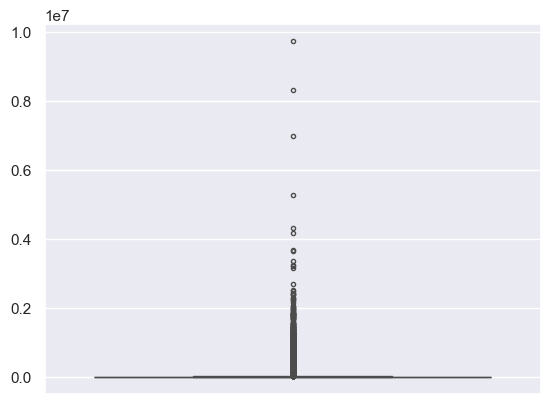

In [85]:
sns.boxplot(users_total_dur['total_dur'].values, fliersize=3)

In [ ]:
# Определение границ для метода межквартильного расстояния
x25 = users_total_dur['total_dur'].quantile(q=0.25)
x75 = users_total_dur['total_dur'].quantile(q=0.75)
left = x25 - 1.5 * (x75 - x25)
right = x75 + 1.5 * (x75 - x25)

In [94]:
# Удаление выбросов
print(users_total_dur.shape)
users_total_dur = users_total_dur[(users_total_dur['total_dur'] >= left) & ((users_total_dur['total_dur'] <= right))]
print(users_total_dur.shape)

(266081, 2)
(237706, 2)


<Axes: >

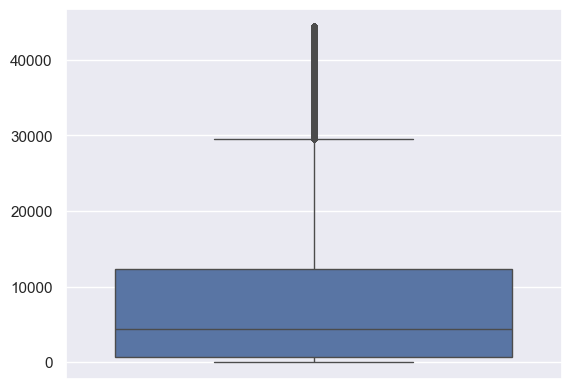

In [105]:
sns.boxplot(users_total_dur['total_dur'].values, fliersize=3)

<details>
    <summary>📝 Визуализация распределения</summary>
    <p>Используем правило Стёрджеса для определения кол-во интервалов. Распределение ненормальное. Значит, что самые популярные критерии (t-test, z-test) для нашей метрики "длина просмотра" не подойдут, так как они требуют условия на нормальность распределения.</p> 
    <p>
    Хотя t-test и z-test предполагает нормальное распределение данных, они также являются достаточно робастными к отклонениям от нормальности, особенно при больших размерах выборок. Если наши выборки действительно большие, то центральная предельная теорема может помочь сделать распределение выборочных средних более нормальным, что позволяет использовать t-test и z-test.<p>
</details>

<Axes: >

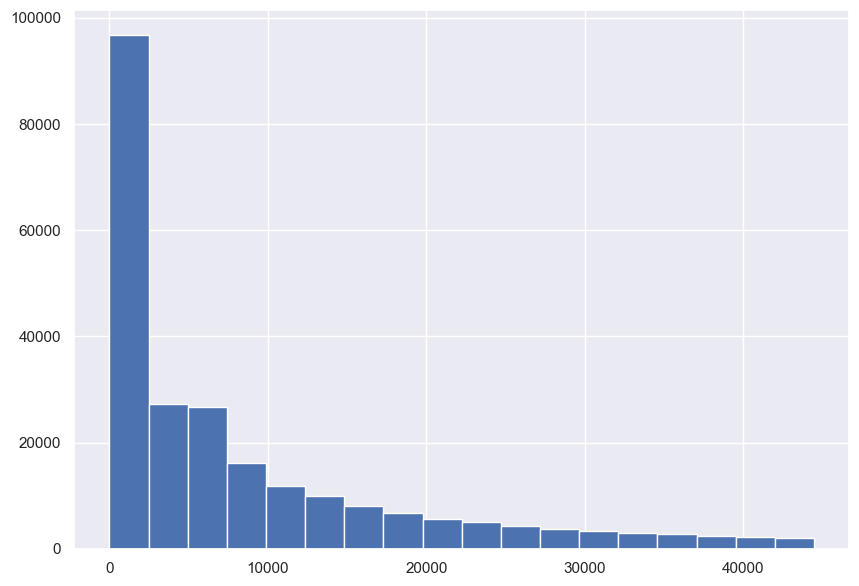

In [103]:
n = int(1 + np.log2(users_total_dur['total_dur'].shape[0]) // 1)
users_total_dur['total_dur'].hist(bins=n, figsize=(10 ,7))

##### Разбиение на группы

Возможные способы:
- рандомное разбиение (при большой выборке)
- стратифицированное разбиение (при малых выборках)

<details>
    <summary>📝 Рандомное разбиение</summary>
    Размер таблицы users_total_dur >> 1000, что позволяет разбить данные на группы рандомным образом. 
    Рандомное разбиение можно реализовать двумя способами:
    <ul>
        <li>Соль + хеширование: позволяет воспроизвести разбиение</li>
        <li>Разбиение с перемешиванием: невозможно воспроизвести</li>
    </ul>
    Оценим визуально распределения формируемых выборок
</details>

Соль + хеширование

In [155]:
# Генерация соли
def salt_generator(salt=None):
    # os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use
    # or we can say this method generates a string containing random characters.
    salt = os.urandom(8)

    # b64encode - кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    return b64encode(salt).decode('ascii')


# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):
    df = df.copy()
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = (df['user_id'].astype(str) + '#' + salt) \
                               .apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2) \
                              .map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [156]:
users_total_dur_group = groups_splitter(users_total_dur, 
                                        columns=['user_id', 'total_dur', 'group'])
users_total_dur_group.head()

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,B
2,1000000,32990,B
3,1000001,52,A
4,1000003,625,B


In [157]:
users_total_dur_group.groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,118970,118970
1,B,118736,118736


array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

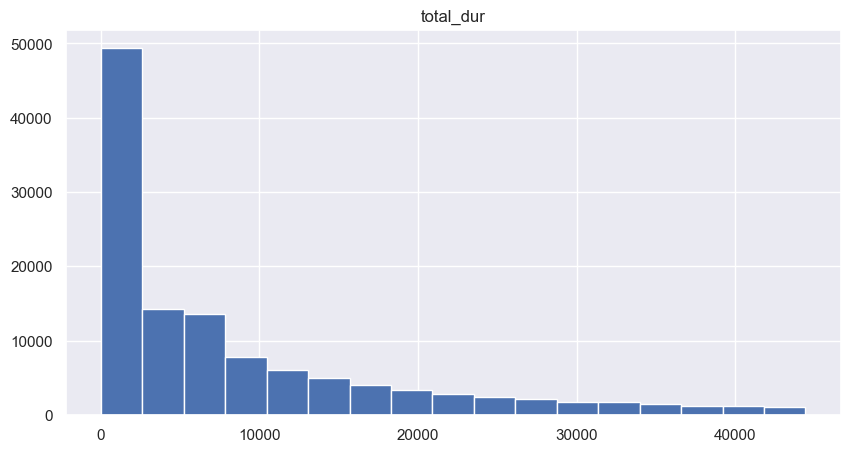

In [146]:
group_A = users_total_dur_group[users_total_dur_group.group == 'A']
n = int(1 + np.log2(group_A['total_dur'].shape[0]) // 1)
group_A.hist(bins=n, figsize=(10 ,5))

array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

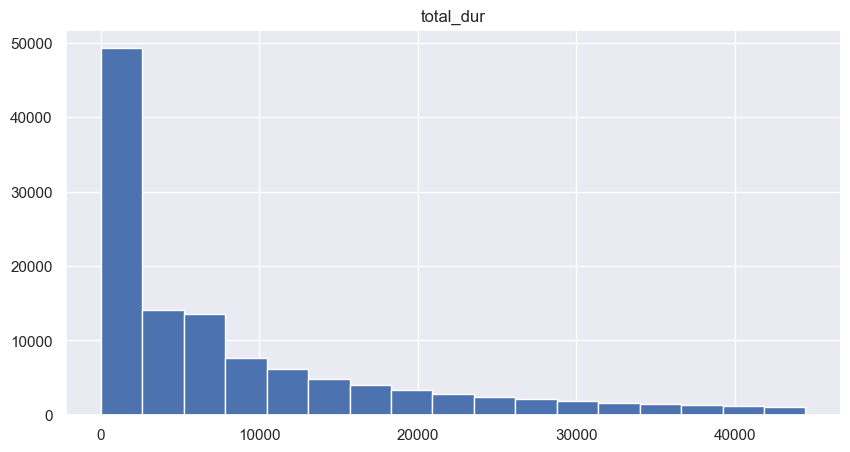

In [147]:
group_B = users_total_dur_group[users_total_dur_group.group == 'B']
n = int(1 + np.log2(group_B['total_dur'].shape[0]) // 1)
group_B.hist(bins=n, figsize=(10 ,5))

Разбиение с перемешиванием

In [158]:
group_A, group_B = train_test_split(users_total_dur, test_size=0.5, shuffle=True)
group_A['group'] = 'A'
group_B['group'] = 'B'

In [159]:
pd.concat([group_A, group_B]).groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,118853,118853
1,B,118853,118853


array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

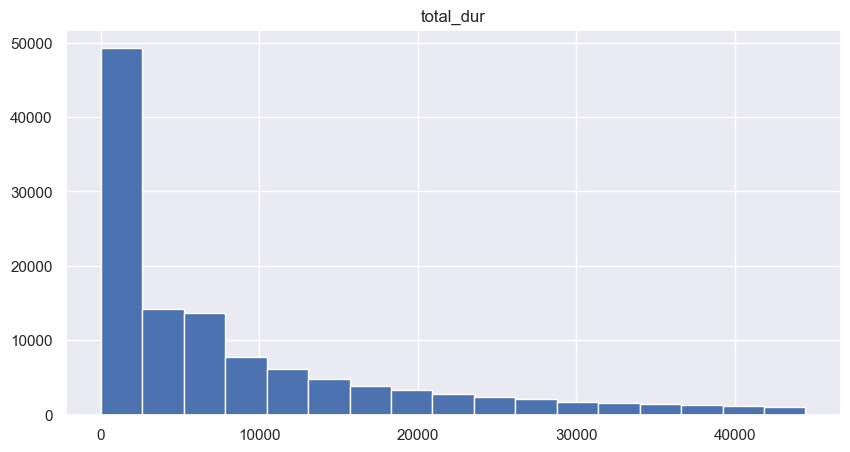

In [160]:
n = int(1 + np.log2(group_A['total_dur'].shape[0]) // 1)
group_A.hist(bins=n, figsize=(10 ,5))

array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

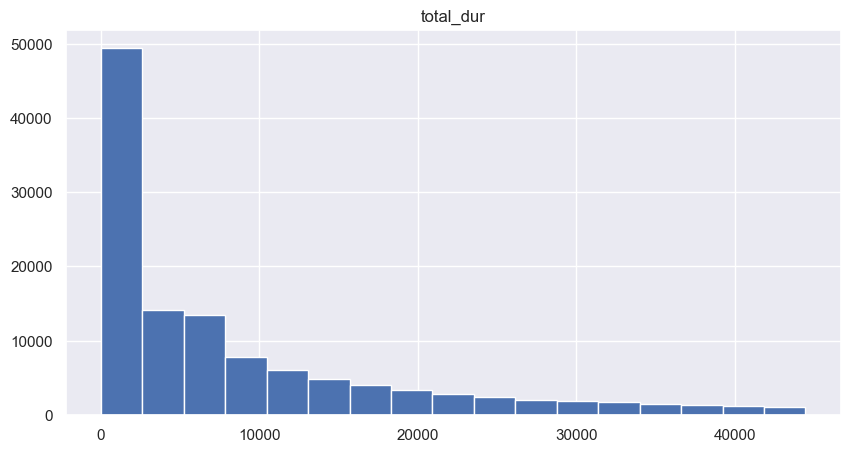

In [161]:
n = int(1 + np.log2(group_B['total_dur'].shape[0]) // 1)
group_B.hist(bins=n, figsize=(10 ,5))

<details>
    <summary>📝 Оценим скорость исполнения</summary>
    Оценим скорость исполнения каждого метода разбиения на группы. Из эксперимента видно, что метод соль + хеширование занимает больше времени, чем разбиение с перемешиванием. У нас нет проблемы воспроизводимости данные (нет необходимости или можно сохранять логи), поэтому в следующих экспериментах будет использоваться второй метод.
</details>

In [153]:
%%time
_ = groups_splitter(users_total_dur,
                    columns=['user_id', 'total_dur', 'group'])

CPU times: total: 125 ms
Wall time: 463 ms


In [154]:
%%time
_ = train_test_split(users_total_dur, 
                     test_size=0.5, 
                     shuffle=True)

CPU times: total: 15.6 ms
Wall time: 19.4 ms


<details>
  <summary>📝 Стратифицированное разбиение </summary>
    <p>Опыт показывает, что применение стратификации к большим выборкам, вместо рандомного разбиения, не дает большого прироста в качестве A/B-тестирования.</p>
    <p>Можно было бы в этом убедиться визуально по графикам. Однако, как упоминалось ранее, в данных присутствует ошибка. При попытке смержить таблицу users с таблицей users_total_dur размер итоговой таблицы меньше размера таблицы users_total_dur. В общем случае теряем 50к данных пользователей.</p>
    <p>То есть, если бы не теряли в данных и применяли стратификацию для разбиения на группы, можно было бы ожидать более качественное разбиение. В нашем случае визуальный анализ теряей всякий смысл.</p>
</details>

In [124]:
users_total_dur

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


In [116]:
users_total_dur.merge(users, how='inner', on=['user_id'])

,user_id,total_dur,age,income,sex,kids_flg
0,1,21172,age_25_34,income_20_40,Ж,1
1,1000,10744,age_45_54,income_20_40,М,0
2,1000001,52,age_45_54,income_20_40,Ж,0
3,1000008,3691,age_25_34,income_40_60,Ж,1
4,1000013,2430,age_35_44,income_40_60,Ж,0
...,...,...,...,...,...,...
187088,99997,30672,age_35_44,income_40_60,Ж,0
187089,999977,4570,age_35_44,income_20_40,Ж,1
187090,999978,11172,age_18_24,income_20_40,Ж,0
187091,999987,27888,age_35_44,income_20_40,М,0


##### Выбор критерия

Возможные критерии:
- параметрические критерии
    - Z-test для разности средних
    - T-test для разности средних
    - Хи-квадрат для разности дисперсий
    - F-критерий для отношения дисперсий
- непараметрические критерии
    - U-критерий Манна-Уитни
    - Критерий Колмогорова-Смирнова
- бутстреп

Метрика нами определена ранее - это TVTu.

Далее рассмотрим следующие сочитания метрика + критерий:
- TVTu + бутстреп
- логарифмированная TVTu + бутстреп
- TVTu + манна-уитни
- логарифмированная TVTu + манна-уитни
- TVTu + t-test
- логарифмированная TVTu + t-test

# Дизайн A/B: TVTu + бутстреп

# Дизайн A/B: лог.TVTu + бутстреп

# Дизайн A/B: TVTu + манна-уитни

##### A/A-тест

Оценка равномерности распределения p-value

In [190]:
pvalues = []
for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  u, p = mannwhitneyu(
        group_A['total_dur'].values,
        group_B['total_dur'].values
    )
  pvalues.append(p)

100%|██████████| 1000/1000 [00:34<00:00, 29.15it/s]


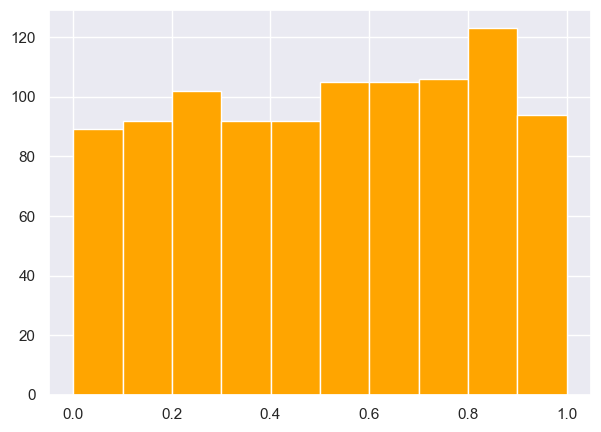

In [191]:
plt.figure(figsize=(7, 5))
n = int(1 + np.log2(len(pvalues)) // 1)
plt.hist(pvalues, bins=n, color='orange');

In [193]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.09692865364702385 - p_values равномерное распределение


# Дизайн A/B: лог.TVTu + манна-уитни

In [194]:
users_total_dur['total_dur_ln'] = np.log2(users_total_dur['total_dur'])

##### A/A-тест

Оценка равномерности распределения p-value

In [195]:
pvalues = []
for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  u, p = mannwhitneyu(
        group_A['total_dur_ln'].values,
        group_B['total_dur_ln'].values
    )
  pvalues.append(p)

100%|██████████| 1000/1000 [00:34<00:00, 29.36it/s]


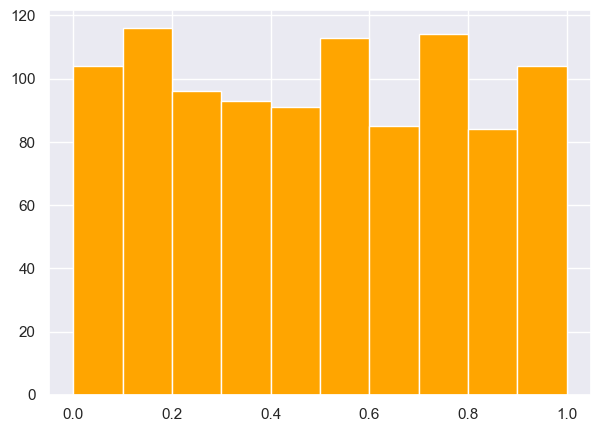

In [196]:
plt.figure(figsize=(7, 5))
n = int(1 + np.log2(len(pvalues)) // 1)
plt.hist(pvalues, bins=n, color='orange');

In [197]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.5958052237302742 - p_values равномерное распределение


# Дизайн A/B: TVTu + t-test

##### A/A-тест

Оценка равномерности распределения p-value

In [185]:
pvalues = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  p = ttest_ind(group_A['total_dur'].values, 
                group_B['total_dur'].values, 
                equal_var=False).pvalue
  pvalues.append(p)

100%|██████████| 1000/1000 [00:20<00:00, 48.94it/s]


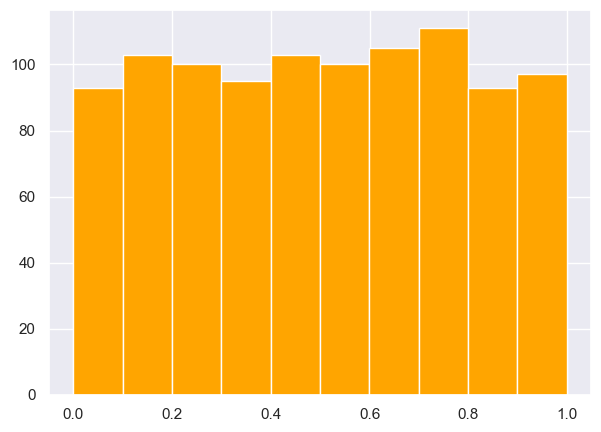

In [187]:
plt.figure(figsize=(7, 5))
n = int(1 + np.log2(len(pvalues)) // 1)
plt.hist(pvalues, bins=n, color='orange');

In [189]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.9633929688871599 - p_values равномерное распределение


# Дизайн A/B: лог.TVTu + t-test

In [199]:
users_total_dur['total_dur_ln'] = np.log2(users_total_dur['total_dur'])

##### A/A-тест

Оценка равномерности распределения p-value

In [200]:
pvalues = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  p = ttest_ind(group_A['total_dur'].values, 
                group_B['total_dur'].values, 
                equal_var=False).pvalue
  pvalues.append(p)

100%|██████████| 1000/1000 [00:23<00:00, 42.36it/s]


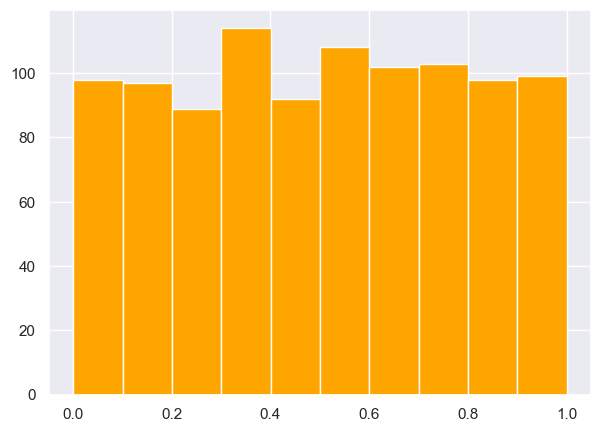

In [201]:
plt.figure(figsize=(7, 5))
n = int(1 + np.log2(len(pvalues)) // 1)
plt.hist(pvalues, bins=n, color='orange');

In [202]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.8013889410139873 - p_values равномерное распределение


# A/B тест